# GWAS Analysis

I want to see whether the eQTLs are enriched for GWAS hits.

In [137]:
import glob
import os
import random
import subprocess

import cdpybio as cpb
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pybedtools as pbt
from scipy.stats import fisher_exact
import seaborn as sns
import tabix

import cardipspy as cpy
import ciepy

%matplotlib inline

In [3]:
import socket
if socket.gethostname() == 'fl1':
    pbt.set_tempdir('/projects/cdeboever/pybedtools_temp')

In [4]:
outdir = os.path.join(ciepy.root, 'output',
                      'gwas_analysis')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'gwas_analysis')
cpy.makedir(private_outdir)

In [5]:
gwas = pd.read_table(cpy.gwas_catalog, low_memory=False)
gwas = gwas.dropna(subset=['CHR_ID', 'CHR_POS'])
gwas['CHR_ID'] = 'chr' + gwas.CHR_ID.astype(int).astype(str)
gwas['CHR_POS'] = gwas.CHR_POS.astype(int)
gwas['hg38_loc'] = gwas.CHR_ID + ':' + gwas.CHR_POS.astype(str)

In [155]:
roadmap_gwas_readme = pd.read_table('/raid3/publicdata/roadmap_gwas/README.txt')
roadmap_gwas_readme.columns = [x.replace('#', '') for x in roadmap_gwas_readme.columns]
roadmap_gwas_readme.index = roadmap_gwas_readme.FILENAME.apply(lambda x: x.replace('.txt.gz', ''))

grasp_phenos = pd.read_table('/raid3/publicdata/grasp/variant_enrichment/grasp_phenotypes_500.tsv', 
                             index_col=0)
grasp_phenos.index = ['grasp_pheno_{}'.format(x) for x in grasp_phenos.index]

In [6]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)
qvalues.columns = ['{}_gene'.format(x) for x in qvalues.columns]
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'most_sig.tsv')
most_sig = pd.read_table(fn, index_col=0)
most_sig = most_sig.join(qvalues)
most_sig = most_sig.drop_duplicates(subset=['gene'])
sig = most_sig[most_sig.sig_gene]
sig = sig.drop_duplicates(subset=['gene'])
sig = sig.drop_duplicates(subset=['chrom', 'coord'])

## GWAS Overlap

In [68]:
s = '\n'.join(sig.chrom + '\t' + (sig.coord - 1).astype(str) + '\t' + 
              sig.coord.astype(str) + '\t' + sig['loc']) + '\n'
sig_bt = pbt.BedTool(s, from_string=True)
sig_bt = sig_bt.sort()

In [164]:
fn = os.path.join(outdir, 'gwas_enrichment.tsv')
if os.path.exists(fn):
    enr = pd.read_table(fn, index_col=0)
else:
    enr = pd.DataFrame(columns=['odds_ratio', 'pvalue'])

In [220]:
dys = glob.glob('/raid3/publicdata/roadmap_gwas/variant_enrichment/EUR*')
dys += glob.glob('/raid3/publicdata/grasp/variant_enrichment/grasp_pheno_*')
for dy in dys:
    pheno = os.path.split(dy)[1]
    #t = pd.read_table(os.path.join(dy, 'independent_snps.tsv'), 
    #                  index_col=0)
    if pheno not in enr.index:
        print(pheno)

grasp_pheno_95
grasp_pheno_96
grasp_pheno_97
grasp_pheno_98
grasp_pheno_99
grasp_pheno_100
grasp_pheno_101
grasp_pheno_102
grasp_pheno_103
grasp_pheno_104
grasp_pheno_105
grasp_pheno_106
grasp_pheno_107
grasp_pheno_108
grasp_pheno_109
grasp_pheno_110
grasp_pheno_111
grasp_pheno_112
grasp_pheno_113
grasp_pheno_114
grasp_pheno_115
grasp_pheno_116
grasp_pheno_117
grasp_pheno_118
grasp_pheno_119
grasp_pheno_122
grasp_pheno_123
grasp_pheno_124
grasp_pheno_125
grasp_pheno_126
grasp_pheno_127
grasp_pheno_128
grasp_pheno_129
grasp_pheno_130
grasp_pheno_131
grasp_pheno_132
grasp_pheno_133
grasp_pheno_134
grasp_pheno_135
grasp_pheno_136
grasp_pheno_137
grasp_pheno_138
grasp_pheno_139
grasp_pheno_140
grasp_pheno_141
grasp_pheno_142
grasp_pheno_143
grasp_pheno_144
grasp_pheno_145
grasp_pheno_146
grasp_pheno_147
grasp_pheno_148
grasp_pheno_149
grasp_pheno_150
grasp_pheno_151
grasp_pheno_152
grasp_pheno_153
grasp_pheno_154
grasp_pheno_155
grasp_pheno_156
grasp_pheno_157
grasp_pheno_158
grasp_pheno_1

In [ ]:
dys = glob.glob('/raid3/publicdata/roadmap_gwas/variant_enrichment/EUR*')
dys += glob.glob('/raid3/publicdata/grasp/variant_enrichment/grasp_pheno_*')
overlaps = []
phenos = []
for dy in dys:
    pheno = os.path.split(dy)[1]
    t = pd.read_table(os.path.join(dy, 'independent_snps.tsv'), 
                      index_col=0)
    if pheno not in enr.index:
        print(pheno)
        bt = pbt.BedTool(os.path.join(dy, 'independent_snps_expanded.bed'))
        res = sig_bt.intersect(bt, sorted=True)
        t = [len(res)]
        for i in range(1000):
            bt = pbt.BedTool(os.path.join(dy, 'null_sets_expanded', 
                                          'null_{}_expanded.bed'.format(i)))
            res = sig_bt.intersect(bt, sorted=True)
            t.append(len(res))
        overlaps.append(t)
        phenos.append(pheno)

In [188]:
df = pd.DataFrame(overlaps, index=phenos,
                  columns=['real'] + range(1000))
null_overlaps = df[range(50)].sum(axis=1)

ors = []
pvalues = []
for p in phenos:
    if 'grasp' in p:
        dy = '/raid3/publicdata/grasp/variant_enrichment/{}'.format(p)
    else:
        dy = '/raid3/publicdata/roadmap_gwas/variant_enrichment/{}'.format(p)
    t = pd.read_table(os.path.join(dy, 'independent_snps.tsv'), 
                      index_col=0)
    sig_gwas = df.ix[p, 'real']
    sig_not_gwas = t.shape[0] - sig_gwas
    null_gwas = null_overlaps[p]
    null_not_gwas = t.shape[0] * 50 - null_gwas
    odds_ratio, p = fisher_exact([[sig_gwas, sig_not_gwas], [null_gwas, null_not_gwas]])
    ors.append(odds_ratio)
    pvalues.append(p)
t = pd.DataFrame({'odds_ratio':ors, 'pvalue':pvalues}, index=phenos)
t['disease'] = roadmap_gwas_readme.ix[t.index, 'DISEASE']
ind = set(t.index) & set(grasp_phenos.index)
t.ix[ind, 'disease'] = grasp_phenos.ix[ind, 'phenotype']
enr = pd.concat([enr, t])
enr = enr.sort(columns='pvalue')
enr.to_csv(os.path.join(outdir, 'gwas_enrichment.tsv'), sep='\t')

In [236]:
enr[enr.disease == 'check website']

,odds_ratio,pvalue,disease
EUR.GIANT_HEIGHT_LangoAllen2010_publicrelease_HapMapCeuFreq_eqtl,1.799901,0.000091,check website
EUR.GIANT_BMI_Speliotes2010_publicrelease_HapMapCeuFreq_eqtl,2.997566,0.000366,check website
EUR.GIANT_Randall2013PlosGenet_stage1_publicrelease_HapMapCeuFreq_HEIGHT_MEN,2.106112,0.000515,check website
EUR.GIANT_Randall2013PlosGenet_stage1_publicrelease_HapMapCeuFreq_HEIGHT_WOMEN,1.937669,0.000986,check website
EUR.GIANT_Randall2013PlosGenet_stage1_publicrelease_HapMapCeuFreq_WEIGHT_MEN,3.180607,0.001361,check website
EUR.MAGIC.Manning_et_al_lnFastingInsulin_MainEffect,8.736842,0.002127,check website
EUR.GIANT_Randall2013PlosGenet_stage1_publicrelease_HapMapCeuFreq_BMI_MEN,3.194553,0.002429,check website
EUR.GIANT_Randall2013PlosGenet_stage1_publicrelease_HapMapCeuFreq_BMI_WOMEN,3.287368,0.013892,check website
EUR.GIANT_Randall2013PlosGenet_stage1_publicrelease_HapMapCeuFreq_WC_MEN,3.527961,0.019861,check website
EUR.GIANT_Randall2013PlosGenet_stage1_publicrelease_HapMapCeuFreq_WHR_WOMEN,3.302558,0.135728,check website


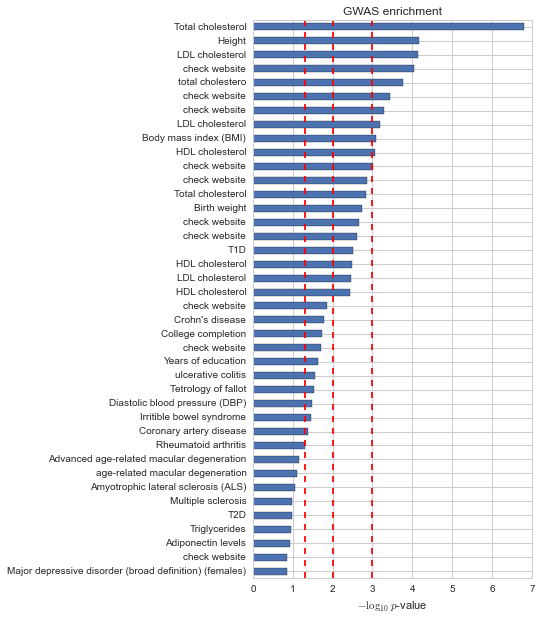

In [234]:
with sns.axes_style('whitegrid'):
    t = enr.sort(columns='pvalue', ascending=False).tail(40)
    t.index = t.disease
    fig, ax = plt.subplots(1, 1, figsize=(5, 10))
    #(-np.log10(t.pvalue.tail(30))).plot(kind='barh')
    (-np.log10(t.pvalue)).plot(kind='barh', ax=ax)
    ax.set_xlabel('$-\log_{10}$ $p$-value')
    ax.set_ylabel('')
    ya, yb = ax.get_ylim()
    ax.vlines(-np.log10(0.05), ya, yb, color='red', linestyle='--')
    ax.vlines(-np.log10(0.01), ya, yb, color='red', linestyle='--')
    ax.vlines(-np.log10(0.001), ya, yb, color='red', linestyle='--')
    ax.set_title('GWAS enrichment')
    #fig.tight_layout();

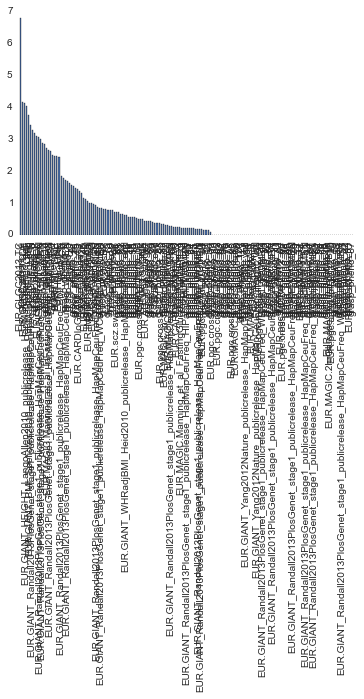

In [230]:
(-np.log10(enr.pvalue)).plot(kind='bar')